#### <b>Download the Original Datasets</b>

* <b>CelebA-HQ Dataset</b>: A dataset consisting of 30,000 "human face" images.
    * This dataset has approximately 3GB of data in size and is one of the most widely used face datasets worldwide.
* <b>CelebA-HQ Identity Dataset</b>: A dataset that provides information about <b>who the individuals (subjects) are</b> for each facial image file.
* <b>CelebA-HQ Attribute Dataset</b>: A dataset that provides attribute information for each facial image file.
    * This attribute information includes <b>gender</b>, <b>smiling</b>, and <b>age</b>, which we will be used for a multi-label task.

In [1]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Eb37jNPPA7hHl0fmktYqcV8B-qmPLx-ZKYQ1eFk4UPBV_A?download=1 -O CelebAMask-HQ.zip
!wget https://postechackr-my.sharepoint.com/:t:/g/personal/dongbinna_postech_ac_kr/EVRoUY8_txRFv56-KWvZrksBDWbD6adkjBxwwRN7qAC6bg?download=1 -O CelebA-HQ-identity.txt
!wget https://postechackr-my.sharepoint.com/:t:/g/personal/dongbinna_postech_ac_kr/EVrdIrPOkR1OlEWBVK8lE3AB9bFh741GnKBkNgPa8trNuA?download=1 -O CelebA-HQ-attribute.txt

--2023-11-03 18:25:20--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Eb37jNPPA7hHl0fmktYqcV8B-qmPLx-ZKYQ1eFk4UPBV_A?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/datasets/CelebAMask-HQ/CelebAMask-HQ.zip?ga=1 [following]
--2023-11-03 18:25:21--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/datasets/CelebAMask-HQ/CelebAMask-HQ.zip?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 3153930546 (2.9G) [application/x-zip-compressed]
Saving to: ‘CelebAMask-HQ.zip’

CelebAMask-HQ.zip   100%[===================>]   2.94G  71.5MB/s    in

In [2]:
%%capture
!rm -rf ./CelebAMask-HQ
!unzip CelebAMask-HQ.zip

#### <b>Load Libraries</b>

* Load various useful python libraries for the experiments.

In [24]:
import os
import time
import random
import glob
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn import linear_model, model_selection

#### <b>Load Identity Mapping</b>
* Check which person each file name is associated with.
* There are a total of 6,217 individuals (subjects) among the 30,000 files.

In [2]:
path = "./"

In [3]:
identities = {}

# (Image File Name, Subject Identity Information)
with open(path + 'CelebA-HQ-identity.txt') as f:
    lines = f.readlines()
    for line in lines:
        file_name, identity = line.strip().split()
        identities[file_name] = identity

print(f'There are {len(set(identities.values()))} identities.')
print(f'There are {len(identities.keys())} images.')

There are 6217 identities.
There are 30000 images.


In [4]:
attribute_path = path + 'CelebA-HQ-attribute.txt'

# Create a dictionary for mapping attributes.
attributes_map = {
    "gender": 21,
    "smiling": 32,
    "young": 40
}

# Initialize a dictionary to store the results.
label_map = {}

with open(attribute_path) as f:
    lines = f.readlines()
    for line in lines[2:]:
        splited = line.strip().split()
        file_name = splited[0]
        label_map[file_name] = {attr: int(splited[idx]) for attr, idx in attributes_map.items()}

print(f'There are {len(label_map.keys())} images.')

sample_key = list(label_map.keys())[0]
print(f'Sample labels for {sample_key}: {label_map[sample_key]}')

There are 30000 images.
Sample labels for 0.jpg: {'gender': -1, 'smiling': 1, 'young': 1}


#### <b>Split the Dataset</b>
* <b>Training dataset  $\mathcal{D}_{train}$</b>: 25,933 images.
* <b>Test dataset $\mathcal{D}_{test}$</b>: 2,065 images.
* <b>Unseen dataset $\mathcal{D}_{unseen}$</b>: 2,002 images.

In [5]:
source_root = path + 'CelebAMask-HQ/CelebA-HQ-img/'

train_index = 190
retain_index = 1250
unseen_index = 4855

In [6]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []

        for image_path in self.image_path_list:
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity >= train_index and identity < unseen_index:
                gender = int(label_map[file_name]["gender"])
                if gender == -1: gender = 0
                smiling = int(label_map[file_name]["smiling"])
                if smiling == -1: smiling = 0
                young = int(label_map[file_name]["young"])
                if young == -1: young = 0
                self.labels.append((gender, identity, smiling, young))
                self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        gender = torch.tensor(label[0])
        identity = torch.tensor(label[1])
        smiling = torch.tensor(label[2])
        young = torch.tensor(label[3])

        return image, (gender, identity, smiling, young)

In [7]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []
        for image_path in self.image_path_list:
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity < train_index:
                gender = int(label_map[file_name]["gender"])
                if gender == -1: gender = 0
                smiling = int(label_map[file_name]["smiling"])
                if smiling == -1: smiling = 0
                young = int(label_map[file_name]["young"])
                if young == -1: young = 0
                self.labels.append((gender, identity, smiling,  young))
                self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        gender = torch.tensor(label[0])
        identity = torch.tensor(label[1])
        smiling = torch.tensor(label[2])
        young = torch.tensor(label[3])

        return image, (gender, identity, smiling, young)

In [8]:
class ForgetDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []

        for image_path in self.image_path_list:
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity >= train_index and identity < retain_index:
                gender = int(label_map[file_name]["gender"])
                if gender == -1: gender = 0
                smiling = int(label_map[file_name]["smiling"])
                if smiling == -1: smiling = 0
                young = int(label_map[file_name]["young"])
                if young == -1: young = 0
                self.labels.append((gender, identity, smiling, young))
                self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        gender = torch.tensor(label[0])
        identity = torch.tensor(label[1])
        smiling = torch.tensor(label[2])
        young = torch.tensor(label[3])

        return image, (gender, identity, smiling, young)

In [9]:
class RetainDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []

        for image_path in self.image_path_list:
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity < unseen_index and identity >= retain_index:
                gender = int(label_map[file_name]["gender"])
                if gender == -1: gender = 0
                smiling = int(label_map[file_name]["smiling"])
                if smiling == -1: smiling = 0
                young = int(label_map[file_name]["young"])
                if young == -1: young = 0
                self.labels.append((gender, identity, smiling, young))
                self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        gender = torch.tensor(label[0])
        identity = torch.tensor(label[1])
        smiling = torch.tensor(label[2])
        young = torch.tensor(label[3])

        return image, (gender, identity, smiling, young)

In [10]:
class UnseenDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []
        for image_path in self.image_path_list:
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity < unseen_index:
                continue
            gender = int(label_map[file_name]["gender"])
            if gender == -1: gender = 0
            smiling = int(label_map[file_name]["smiling"])
            if smiling == -1: smiling = 0
            young = int(label_map[file_name]["young"])
            if young == -1: young = 0
            self.labels.append((gender, identity, smiling, young))
            self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        gender = torch.tensor(label[0])
        identity = torch.tensor(label[1])
        smiling = torch.tensor(label[2])
        young = torch.tensor(label[3])

        return image, (gender, identity, smiling, young)

In [11]:
train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

unseen_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

train_set = TrainDataset(transform=train_transform)
test_set = TestDataset(transform=test_transform)
forget_set_train = ForgetDataset(transform=train_transform)
forget_set_test = ForgetDataset(transform=test_transform)
retain_set_train = RetainDataset(transform=train_transform)
retain_set_test = RetainDataset(transform=test_transform)
unseen_set = UnseenDataset(transform=unseen_transform)

In [12]:
print('Train dataset size:', len(train_set))
print('Test dataset size:', len(test_set))
print('Forget dataset size:', len(forget_set_train))
print('Retain dataset size:', len(retain_set_train))
print('Unseen dataset size:', len(unseen_set))

Train dataset size: 25846
Test dataset size: 2053
Forget dataset size: 10135
Retain dataset size: 15711
Unseen dataset size: 2001



* In the NeurIPS Competition setting, when performing machine unlearning, training is done with 'retain' and 'forget', so augmentation can be applied. However, it should never be applied during evaluation.

In [13]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
forget_dataloader_train = torch.utils.data.DataLoader(forget_set_train, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
forget_dataloader_test = torch.utils.data.DataLoader(forget_set_test, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
retain_dataloader_train = torch.utils.data.DataLoader(retain_set_train, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
retain_dataloader_test = torch.utils.data.DataLoader(retain_set_test, batch_size=64, shuffle=False, num_workers=2,pin_memory=True)
unseen_dataloader = torch.utils.data.DataLoader(unseen_set, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

In [14]:
train_image_paths = TrainDataset().image_paths
test_image_paths = TestDataset().image_paths
forget_image_paths = ForgetDataset().image_paths
retain_image_paths = RetainDataset().image_paths
unseen_image_paths = UnseenDataset().image_paths

train_test_overlap = len(set(train_image_paths) & set(test_image_paths))
train_forget_overlap = len(set(train_image_paths) & set(forget_image_paths))
train_retain_overlap = len(set(train_image_paths) & set(retain_image_paths))
train_unseen_overlap = len(set(train_image_paths) & set(unseen_image_paths))
test_forget_overlap = len(set(test_image_paths) & set(forget_image_paths))
test_retain_overlap = len(set(test_image_paths) & set(retain_image_paths))
test_unseen_overlap = len(set(test_image_paths) & set(unseen_image_paths))
forget_retain_overlap = len(set(forget_image_paths) & set(retain_image_paths))
forget_unseen_overlap = len(set(forget_image_paths) & set(unseen_image_paths))
retain_unseen_overlap = len(set(retain_image_paths) & set(unseen_image_paths))

overlap_dict = {
    'train_test': train_test_overlap,
    'train_forget': train_forget_overlap,
    'train_retain': train_retain_overlap,
    'train_unseen': train_unseen_overlap,
    'test_forget': test_forget_overlap,
    'test_retain': test_retain_overlap,
    'test_unseen': test_unseen_overlap,
    'forget_retain': forget_retain_overlap,
    'forget_unseen': forget_unseen_overlap,
    'retain_unseen': retain_unseen_overlap
}
overlap_dict

{'train_test': 0,
 'train_forget': 10135,
 'train_retain': 15711,
 'train_unseen': 0,
 'test_forget': 0,
 'test_retain': 0,
 'test_unseen': 0,
 'forget_retain': 0,
 'forget_unseen': 0,
 'retain_unseen': 0}

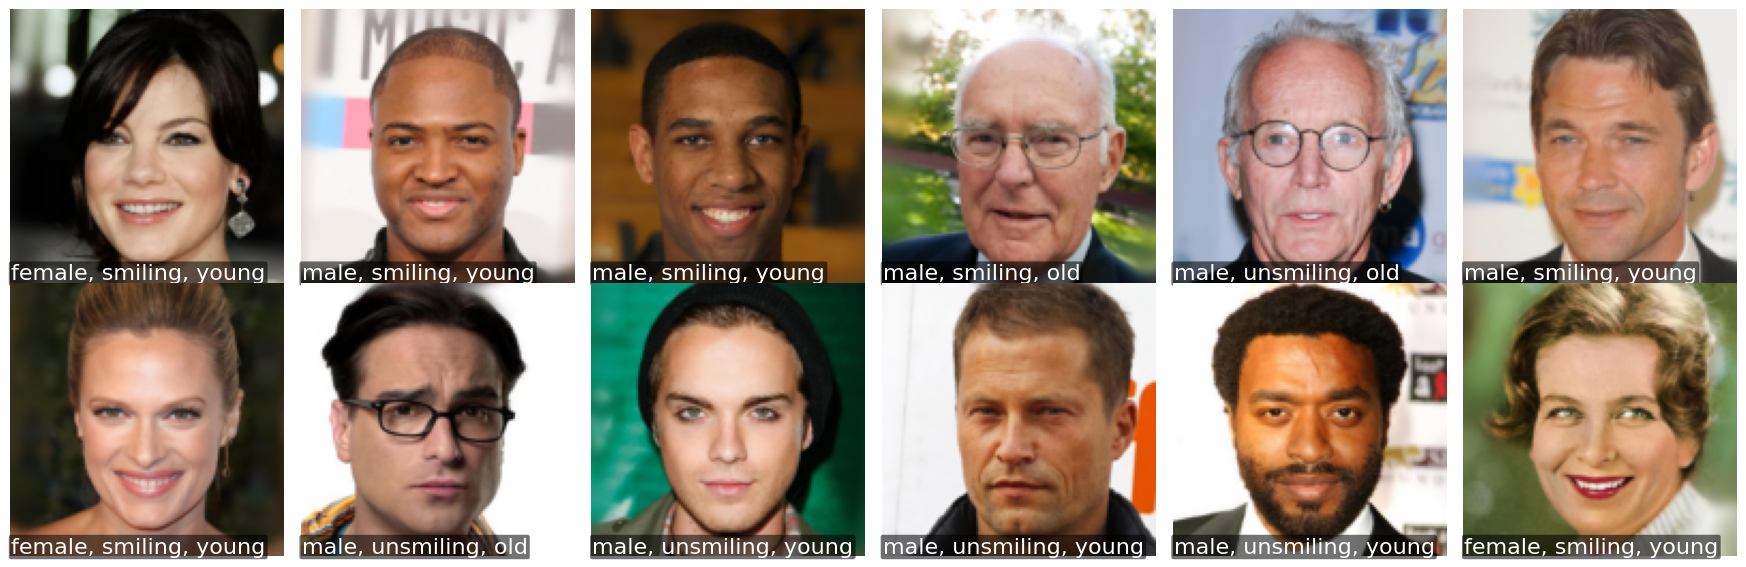

In [15]:
def label_to_string(gender, smiling, young):
    gender_str = "male" if gender == 1 else "female"
    smiling_str = "smiling" if smiling == 1 else "unsmiling"
    young_str = "young" if young == 1 else "old"
    return f"{gender_str}, {smiling_str}, {young_str}"

def show_images(images, labels, nrow=6, save_path = None):
    n_images = 12
    images = images[:12]
    labels = labels[:12]
    nrows = (n_images + nrow - 1) // nrow

    # Create a grid of subplots
    fig, axs = plt.subplots(nrows, nrow, figsize=(22.5, 7.1))
    axs = axs.ravel()  # Flatten the array of axes
    plt.subplots_adjust(wspace=0, hspace=0)

    for i in range(n_images):
        img = images[i].numpy().transpose((1, 2, 0))
        label_str = label_to_string(labels[0][i].item(), labels[2][i].item(), labels[3][i].item())
        axs[i].imshow(img)
        axs[i].axis('off')

        axs[i].text(0, img.shape[0], label_str, color='white', fontsize=16,
                    ha='left', va='bottom',
                    bbox=dict(facecolor='black', alpha=0.55, edgecolor='none', boxstyle='round,pad=0.1'))
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1, dpi=300)
    plt.show()

images, labels = next(iter(unseen_dataloader))
show_images(images, labels, nrow=6)

#### <b>(Option) Load the Pre-trained Original Model</b>

* We can easily download the pre-trained original model, rather than training the original model from scratch.
* <b>Download Link</b>: https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebdiwb9ujSNFvciQumF9dJUBXrEgBOB4xiZrdp4YmLpMyw

In [22]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebdiwb9ujSNFvciQumF9dJUBXrEgBOB4xiZrdp4YmLpMyw?download=1 -O pre_trained_last_checkpoint_epoch_8.pth

--2023-11-03 18:32:23--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebdiwb9ujSNFvciQumF9dJUBXrEgBOB4xiZrdp4YmLpMyw?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/Machine%20Unlearning/last_checkpoint_epoch_8.pth?ga=1 [following]
--2023-11-03 18:32:24--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/Machine%20Unlearning/last_checkpoint_epoch_8.pth?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 44771195 (43M) [application/octet-stream]
Saving to: ‘pre_trained_last_checkpoint_epoch_8.pth’

pre_trained_last_ch 100%[

In [16]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [17]:
# Define a custom head for the multi-label classification.
class MultiLabelHead(nn.Module):
    def __init__(self, in_features, out_features):
        super(MultiLabelHead, self).__init__()
        self.fc = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.fc(x)

In [18]:
def train(model, dataloader):
    set_seed(42)

    model.train()
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')

    running_loss = 0.
    running_corrects = 0
    running_corrects_gender = 0
    running_corrects_smiling = 0
    running_corrects_young = 0

    print_every = 20
    batch_losses = []

    # Load a batch data of images.
    for i, (inputs, (gender, identity, smiling, young)) in enumerate(dataloader):
        inputs = inputs.cuda()

        # Convert labels to the same format as the outputs (float).
        labels = torch.stack((gender, smiling, young), dim=1).type(torch.FloatTensor).cuda()

        # Forward inputs and get output.
        optimizer.zero_grad()
        outputs = model(inputs)
        probs = torch.sigmoid(outputs)

        loss = criterion(outputs, labels)
        batch_losses.append(loss.item())

        # Get loss value and update the network weights.
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Calculate accuracy for the current batch.
        threshold = 0.5
        preds = (probs > threshold).int()
        corrects = torch.sum(preds == labels.int()).item()
        running_corrects += corrects

        # Calculate accuracy for each label in the current batch.
        corrects_gender = torch.sum(preds[:, 0] == gender.int().to(device)).item()
        corrects_smiling = torch.sum(preds[:, 1] == smiling.int().to(device)).item()
        corrects_young = torch.sum(preds[:, 2] == young.int().to(device)).item()
        running_corrects_gender += corrects_gender
        running_corrects_smiling += corrects_smiling
        running_corrects_young += corrects_young

        # Print average loss for the last 'print_every' batches.
        if (i + 1) % print_every == 0:
            avg_loss = sum(batch_losses) / print_every
            print(f"[Batch {i+1}] Avg. Loss: {avg_loss:.4f}")
            batch_losses = []

    # Calculate average training accuracy.
    acc_avg = running_corrects / (len(dataloader.dataset) * 3)

    # Calculate average accuracy for each label.
    acc_gender = running_corrects_gender / len(dataloader.dataset)
    acc_smiling = running_corrects_smiling / len(dataloader.dataset)
    acc_young = running_corrects_young / len(dataloader.dataset)

    loss = running_loss / len(train_set)
    print('[Train] Loss: {:.4f}, Average Training Accuracy: {:.2f}, '
          'Gender Acc: {:.2f}, Smiling Acc: {:.2f}, Young Acc: {:.2f}, Time: {:.4f}s'.format(
        loss, acc_avg, acc_gender, acc_smiling, acc_young, time.time() - start_time))

    return loss, (acc_avg, acc_gender, acc_smiling, acc_young)

In [19]:
def test(model, dataloader):

    start_time = time.time()
    print(f'[Test]')
    model.eval()

    with torch.no_grad():
        running_loss = 0.
        total_corrects_gender = 0
        total_corrects_smiling = 0
        total_corrects_young = 0

        for inputs, (gender, identity, smiling, young) in dataloader:
            inputs = inputs.cuda()

            # Convert labels to the same format as the outputs (float)
            labels = torch.stack((gender, smiling, young), dim=1).type(torch.FloatTensor).cuda()

            outputs = model(inputs)
            probs = torch.sigmoid(outputs)

            loss = criterion(outputs, labels)

            # Calculate accuracy for each label
            threshold = 0.5
            preds = (probs > threshold).int()
            total_corrects_gender += torch.sum(preds[:, 0] == gender.cuda())
            total_corrects_smiling += torch.sum(preds[:, 1] == smiling.cuda())
            total_corrects_young += torch.sum(preds[:, 2] == young.cuda())

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(test_set)
        acc_gender = total_corrects_gender.item() / len(test_set)
        acc_smiling = total_corrects_smiling.item() / len(test_set)
        acc_young = total_corrects_young.item() / len(test_set)
        acc_avg = (acc_gender + acc_smiling + acc_young) / 3.0

        print('Loss: {:.4f} Time: {:.4f}s'.format(epoch_loss, time.time() - start_time))
        print('Average Accuracy: {:.2f} | Gender Acc: {:.2f} | Smiling Acc: {:.2f} | Young Acc: {:.2f}'.format(
            acc_avg, acc_gender, acc_smiling, acc_young
        ))

        return epoch_loss, (acc_avg, acc_gender, acc_smiling, acc_young)

In [20]:
@torch.no_grad()
def evaluation(model, data_loader):
    model.eval()

    running_loss_gender = 0.
    running_corrects_gender = 0

    running_loss_smiling = 0.
    running_corrects_smiling = 0

    running_loss_young = 0.
    running_corrects_young = 0

    for inputs, (gender, identity, smiling, young) in data_loader:
        inputs = inputs.cuda()
        gender = gender.cuda()
        smiling = smiling.cuda()
        young = young.cuda()

        outputs = model(inputs)

        probs = torch.sigmoid(outputs)
        outputs_gender = probs[:, 0]
        outputs_smiling = probs[:, 1]
        outputs_young = probs[:, 2]

        preds_gender = (outputs_gender > 0.5).long()
        preds_smiling = (outputs_smiling > 0.5).long()
        preds_young = (outputs_young > 0.5).long()

        running_corrects_gender += torch.sum(preds_gender == gender)
        running_corrects_smiling += torch.sum(preds_smiling == smiling)
        running_corrects_young += torch.sum(preds_young == young)

    epoch_acc_gender = running_corrects_gender.item() / len(data_loader.dataset)
    epoch_acc_smiling = running_corrects_smiling.item() / len(data_loader.dataset)
    epoch_acc_young = running_corrects_young.item() / len(data_loader.dataset)

    avg_accuracy = (epoch_acc_gender + epoch_acc_smiling + epoch_acc_young) / 3

    return {
        'Average Acc': avg_accuracy,
        'Gender Acc': epoch_acc_gender,
        'Smiling Acc': epoch_acc_smiling,
        'Young Acc': epoch_acc_young,
    }

In [21]:
def compute_losses(net, loader):
    criterion = nn.BCEWithLogitsLoss(reduction="none")
    all_losses = []

    for inputs, (gender, identity, smiling, young) in loader:
        labels = torch.stack((gender, smiling,  young), dim=1).type(torch.FloatTensor)
        inputs, labels = inputs.cuda(), labels.cuda()

        logits = net(inputs)

        losses = criterion(logits, labels).mean(dim=1).cpu().detach().numpy()
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

def cal_mia(model):
    set_seed(42)

    forget_losses = compute_losses(model, forget_dataloader_test)
    unseen_losses = compute_losses(model, unseen_dataloader)

    np.random.shuffle(forget_losses)
    forget_losses = forget_losses[: len(unseen_losses)]

    samples_mia = np.concatenate((unseen_losses, forget_losses)).reshape((-1, 1))
    labels_mia = [0] * len(unseen_losses) + [1] * len(forget_losses)

    mia_scores = simple_mia(samples_mia, labels_mia)
    forgetting_score = abs(0.5 - mia_scores.mean())

    return {'MIA': mia_scores.mean(), 'Forgeting Score': forgetting_score}

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<b>Performance Test</b>

In [25]:
criterion = nn.BCEWithLogitsLoss()

model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = MultiLabelHead(num_features, 3)
model = model.cuda()
# model_path = f'last_checkpoint_epoch_{num_original_epochs}.pth' # If you trian the original model from scratch.
model_path = f'pre_trained_last_checkpoint_epoch_8.pth'
model.load_state_dict(torch.load(model_path))

test_loss, test_acc = test(model, test_dataloader)
print("test loss:", test_loss)
print("test acc:", test_acc)

[Test]
Loss: 0.2680 Time: 7.5196s
Average Accuracy: 0.89 | Gender Acc: 0.91 | Smiling Acc: 0.91 | Young Acc: 0.83
test loss: 0.2680267594206699
test acc: (0.8852086377658711, 0.913297613248904, 0.9147588894301023, 0.8275694106186069)


#### <b>Machine Unlearning Experiments</b>

#### <b>Fine-Tuning</b>
* A method where the original model undergoes further training solely on the retain dataset.
* This approach aims to reinforce the model's knowledge of the retain dataset, potentially leading to the forgetting of the previously learned forget dataset.

In [27]:
unlearned_model = models.resnet18(pretrained=True)
num_features = unlearned_model.fc.in_features
unlearned_model.fc = MultiLabelHead(num_features, 3)
unlearned_model = unlearned_model.cuda()
# model_path = f'last_checkpoint_epoch_{num_original_epochs}_multi_label.pth'
model_path = f'pre_trained_last_checkpoint_epoch_8.pth'
unlearned_model.load_state_dict(torch.load(model_path))

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(unlearned_model.parameters(), lr=0.001)

In [28]:
set_seed(42)
num_epochs = 2
for epoch in range(num_epochs):
    train(unlearned_model, retain_dataloader_train)
    test(unlearned_model, test_dataloader)

[Epoch: 1 - Training]
[Batch 20] Avg. Loss: 0.2947
[Batch 40] Avg. Loss: 0.2488
[Batch 60] Avg. Loss: 0.2894
[Batch 80] Avg. Loss: 0.2768
[Batch 100] Avg. Loss: 0.2759
[Batch 120] Avg. Loss: 0.2801
[Batch 140] Avg. Loss: 0.2696
[Batch 160] Avg. Loss: 0.2461
[Batch 180] Avg. Loss: 0.2614
[Batch 200] Avg. Loss: 0.2620
[Batch 220] Avg. Loss: 0.2571
[Batch 240] Avg. Loss: 0.2660
[Train] Loss: 0.1629, Average Training Accuracy: 0.88, Gender Acc: 0.94, Smiling Acc: 0.89, Young Acc: 0.83, Time: 60.6378s
[Test]
Loss: 0.1902 Time: 7.7641s
Average Accuracy: 0.92 | Gender Acc: 0.97 | Smiling Acc: 0.93 | Young Acc: 0.87
[Epoch: 2 - Training]
[Batch 20] Avg. Loss: 0.2673
[Batch 40] Avg. Loss: 0.2378
[Batch 60] Avg. Loss: 0.2752
[Batch 80] Avg. Loss: 0.2599
[Batch 100] Avg. Loss: 0.2629
[Batch 120] Avg. Loss: 0.2659
[Batch 140] Avg. Loss: 0.2579
[Batch 160] Avg. Loss: 0.2368
[Batch 180] Avg. Loss: 0.2498
[Batch 200] Avg. Loss: 0.2525
[Batch 220] Avg. Loss: 0.2461
[Batch 240] Avg. Loss: 0.2557
[Train

In [29]:
test_acc = evaluation(unlearned_model, test_dataloader)
unseen_acc = evaluation(unlearned_model, unseen_dataloader)
mia = cal_mia(unlearned_model.cuda())
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Average Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

Test Acc: {'Average Acc': 0.9210910862152947, 'Gender Acc': 0.964929371651242, 'Smiling Acc': 0.9264490988796883, 'Young Acc': 0.8718947881149537}
Unseen Acc: {'Average Acc': 0.8825587206396802, 'Gender Acc': 0.9500249875062469, 'Smiling Acc': 0.8750624687656172, 'Young Acc': 0.8225887056471765}
MIA: {'MIA': 0.5543640897755611, 'Forgeting Score': 0.054364089775561064}
Final Score: 0.9061814533320862


#### <b>CF-k (Class-wise Forgetting)</b>
* A strategy that fine-tunes specific layers to make the model forget target data while retaining class structures.

In [31]:
unlearned_model = models.resnet18(pretrained=True)
num_features = unlearned_model.fc.in_features
unlearned_model.fc = MultiLabelHead(num_features, 3)
unlearned_model = unlearned_model.cuda()
# model_path = f'last_checkpoint_epoch_{num_original_epochs}_multi_label.pth'
model_path = f'pre_trained_last_checkpoint_epoch_8.pth'
unlearned_model.load_state_dict(torch.load(model_path))

criterion = nn.BCEWithLogitsLoss()

In [32]:
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, unlearned_model.parameters()), lr=0.001)

In [33]:
set_seed(42)

# Freeze all the parameters
for param in unlearned_model.parameters():
    param.requires_grad = False

# Only unfreeze the last three layers for fine-tuning
for param in unlearned_model.layer3.parameters():
    param.requires_grad = True
for param in unlearned_model.layer4.parameters():
    param.requires_grad = True
for param in unlearned_model.avgpool.parameters():
    param.requires_grad = True
for param in unlearned_model.fc.parameters():
    param.requires_grad = True

num_epochs = 2
for epoch in range(num_epochs):
    train(unlearned_model, retain_dataloader_train)
    test(unlearned_model, test_dataloader)

[Epoch: 1 - Training]
[Batch 20] Avg. Loss: 0.2966
[Batch 40] Avg. Loss: 0.2507
[Batch 60] Avg. Loss: 0.2931
[Batch 80] Avg. Loss: 0.2826
[Batch 100] Avg. Loss: 0.2773
[Batch 120] Avg. Loss: 0.2868
[Batch 140] Avg. Loss: 0.2719
[Batch 160] Avg. Loss: 0.2521
[Batch 180] Avg. Loss: 0.2719
[Batch 200] Avg. Loss: 0.2698
[Batch 220] Avg. Loss: 0.2637
[Batch 240] Avg. Loss: 0.2708
[Train] Loss: 0.1659, Average Training Accuracy: 0.88, Gender Acc: 0.93, Smiling Acc: 0.88, Young Acc: 0.83, Time: 67.4620s
[Test]
Loss: 0.1949 Time: 8.3809s
Average Accuracy: 0.92 | Gender Acc: 0.96 | Smiling Acc: 0.92 | Young Acc: 0.87
[Epoch: 2 - Training]
[Batch 20] Avg. Loss: 0.2752
[Batch 40] Avg. Loss: 0.2425
[Batch 60] Avg. Loss: 0.2851
[Batch 80] Avg. Loss: 0.2719
[Batch 100] Avg. Loss: 0.2705
[Batch 120] Avg. Loss: 0.2773
[Batch 140] Avg. Loss: 0.2653
[Batch 160] Avg. Loss: 0.2490
[Batch 180] Avg. Loss: 0.2663
[Batch 200] Avg. Loss: 0.2660
[Batch 220] Avg. Loss: 0.2592
[Batch 240] Avg. Loss: 0.2648
[Train

In [34]:
test_acc = evaluation(unlearned_model, test_dataloader)
unseen_acc = evaluation(unlearned_model, unseen_dataloader)
mia = cal_mia(unlearned_model.cuda())
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Average Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

Test Acc: {'Average Acc': 0.9194674460139632, 'Gender Acc': 0.9629810034096444, 'Smiling Acc': 0.9235265465172917, 'Young Acc': 0.8718947881149537}
Unseen Acc: {'Average Acc': 0.8832250541395968, 'Gender Acc': 0.9515242378810594, 'Smiling Acc': 0.8775612193903048, 'Young Acc': 0.8205897051474262}
MIA: {'MIA': 0.5543640897755611, 'Forgeting Score': 0.054364089775561064}
Final Score: 0.9053696332314205
